# Progetto Machine Learning: Riconoscimento di Specie di Uccelli con CNN

Questo notebook implementa un sistema di riconoscimento di specie di uccelli attraverso l'analisi di registrazioni audio della competizione BirdClef 2025. Il progetto utilizza un'architettura CNN per classificare gli audio convertiti in spettrogrammi Mel e include anche un sistema di configurazione automatica dell'ambiente per eseguire il codice su Kaggle, Google Colab o in locale.

## 1. Importazione delle Librerie Necessarie

Importiamo tutte le librerie necessarie per l'elaborazione audio, deep learning e visualizzazione.

In [1]:
# Librerie di sistema e utilità
import os
import sys
import platform
import time
import warnings
import logging
import datetime
from pathlib import Path
import pprint as pp
import seaborn as sns
from collections import Counter
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Sostituisci le importazioni di Transformers con timm
import timm

# Librerie per data science e manipolazione dati
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Librerie per elaborazione audio
import librosa
import librosa.display

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T

# Visualizzazione
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Ignoriamo i warning
warnings.filterwarnings("ignore")

# Configurazione del logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('BirdClef')

print("Librerie importate con successo!")
print(f"PyTorch versione: {torch.__version__}")
print(f"timm versione: {timm.__version__}")
print(f"Python versione: {platform.python_version()}")
print(f"Sistema operativo: {platform.system()} {platform.release()}")

Librerie importate con successo!
PyTorch versione: 2.5.1+cu124
timm versione: 1.0.14
Python versione: 3.11.11
Sistema operativo: Linux 6.6.56+


In [2]:
import shutil
import os

# Imposta questo a True per abilitare la cancellazione
clear_working_dir = True

working_dir = '/kaggle/working/'

if clear_working_dir:
    for filename in os.listdir(working_dir):
        file_path = os.path.join(working_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # elimina file o link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # elimina directory
        except Exception as e:
            print(f'Errore durante la rimozione di {file_path}: {e}')
    print(f"Tutti i file in {working_dir} sono stati rimossi.")
else:
    print("Pulizia disabilitata (clear_working_dir = False)")


Tutti i file in /kaggle/working/ sono stati rimossi.


## 2. Configurazione dell'Ambiente di Esecuzione

In questa sezione configuriamo l'ambiente di esecuzione in modo che il notebook funzioni sia su Kaggle, che su Google Colab, che in locale. Il codice rileverà automaticamente l'ambiente e configurerà i percorsi di conseguenza.

In [3]:
# Variabile per impostare manualmente l'ambiente
# Modifica questa variabile in base all'ambiente in uso:
# - 'kaggle' per l'ambiente Kaggle
# - 'colab' per Google Colab
# - 'local' per l'esecuzione in locale
MANUAL_ENVIRONMENT = ''  # Impostare su 'kaggle', 'colab', o 'local' per forzare l'ambiente

def detect_environment():
    """
    Rileva se il notebook è in esecuzione su Kaggle, Google Colab o in locale.
    Rispetta l'impostazione manuale se fornita.
    
    Returns:
        str: 'kaggle', 'colab', o 'local'
    """
    # Se l'ambiente è stato impostato manualmente, usa quello
    if MANUAL_ENVIRONMENT in ['kaggle', 'colab', 'local']:
        print(f"Utilizzo ambiente impostato manualmente: {MANUAL_ENVIRONMENT}")
        return MANUAL_ENVIRONMENT
    
    # Verifica Kaggle con metodo più affidabile
    # Verifica l'esistenza di directory specifiche di Kaggle
    if os.path.exists('/kaggle/working') and os.path.exists('/kaggle/input'):
        print("Rilevato ambiente Kaggle")
        return 'kaggle'
    
    # Verifica se è Google Colab
    try:
        import google.colab
        return 'colab'
    except ImportError:
        pass
    
    # Se non è né Kaggle né Colab, allora è locale
    return 'local'

# Rileva l'ambiente attuale
ENVIRONMENT = detect_environment()
print(f"Ambiente rilevato: {ENVIRONMENT}")

Rilevato ambiente Kaggle
Ambiente rilevato: kaggle


In [4]:
class Config:
    def __init__(self):
        # Rileva l'ambiente
        self.environment = ENVIRONMENT  # Usa la variabile globale impostata in precedenza
        
        # Imposta i percorsi di base in base all'ambiente
        if self.environment == 'kaggle':
            self.COMPETITION_NAME = "birdclef-2025"
            self.BASE_DIR = f"/kaggle/input/{self.COMPETITION_NAME}"
            self.OUTPUT_DIR = "/kaggle/working"
            self.MODELS_DIR = "/kaggle/input"  # Per i modelli pre-addestrati
            
            # Imposta subito i percorsi derivati per l'ambiente Kaggle
            self._setup_derived_paths()
            
        elif self.environment == 'colab':
            # In Colab, inizializza directory base temporanee
            self.COMPETITION_NAME = "birdclef-2025"
            self.OUTPUT_DIR = "/content/output"
            self.MODELS_DIR = "/content/models"
            
            # Crea le directory di output
            os.makedirs(self.OUTPUT_DIR, exist_ok=True)
            os.makedirs(self.MODELS_DIR, exist_ok=True)
            
            # In Colab, BASE_DIR verrà impostato dopo il download
            # quindi non impostiamo ancora i percorsi derivati
            self.BASE_DIR = "/content/placeholder"  # Verrà sovrascritto dopo il download
            
            # Inizializza i percorsi dei file a None per ora
            self.TRAIN_AUDIO_DIR = None
            self.TEST_SOUNDSCAPES_DIR = None
            self.TRAIN_CSV_PATH = None
            self.TAXONOMY_CSV_PATH = None
            self.SAMPLE_SUB_PATH = None
            
        else:  # locale
            # In ambiente locale, i percorsi dipenderanno dalla tua configurazione
            self.BASE_DIR = os.path.abspath(".")
            self.OUTPUT_DIR = os.path.join(self.BASE_DIR, "output")
            self.MODELS_DIR = os.path.join(self.BASE_DIR, "models")
            
            # Crea le directory se non esistono
            os.makedirs(self.OUTPUT_DIR, exist_ok=True)
            os.makedirs(self.MODELS_DIR, exist_ok=True)
            
            # Imposta i percorsi derivati
            self._setup_derived_paths()
        
        # Parametri per il preprocessing audio - già allineati con vincitori
        self.SR = 32000      # Sample rate
        self.DURATION = 5    # Durata dei clip in secondi
        self.N_MELS = 128    # Numero di bande Mel
        self.N_FFT = 1024    # Dimensione finestra FFT
        self.HOP_LENGTH = 512  # Hop length per STFT
        self.FMIN = 20       # Frequenza minima per lo spettrogramma Mel
        self.FMAX = 16000    # Frequenza massima
        self.POWER = 2       # Esponente per calcolo spettrogramma
            
        # Parametri per il training - aggiornati secondo i vincitori
        self.BATCH_SIZE = 96  # Aumentato da 32 a 96 come dai vincitori
        self.EPOCHS = 15     # Numero di epoche per il training
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.NUM_WORKERS = 4  # Aumentato per migliorare il data loading

        # Parametri per inference/submission
        self.TEST_CLIP_DURATION = 5  # Durata dei segmenti per la predizione (secondi)
        self.N_CLASSES = 0  # Sarà impostato dopo aver caricato i dati

    def _setup_derived_paths(self):
        """Imposta i percorsi derivati basati su BASE_DIR"""
        # Utilizza la normale divisione di percorso di OS (non il backslash hardcoded)
        self.TRAIN_AUDIO_DIR = os.path.join(self.BASE_DIR, "train_audio")
        self.TEST_SOUNDSCAPES_DIR = os.path.join(self.BASE_DIR, "test_soundscapes")
        self.TRAIN_CSV_PATH = os.path.join(self.BASE_DIR, "train.csv")
        self.TAXONOMY_CSV_PATH = os.path.join(self.BASE_DIR, "taxonomy.csv") 
        self.SAMPLE_SUB_PATH = os.path.join(self.BASE_DIR, "sample_submission.csv")

In [5]:
config = Config()

# Gestione download dati in Colab con kagglehub
if config.environment == 'colab':
    # Percorsi nella cache di kagglehub
    cache_competition_path = "/root/.cache/kagglehub/competitions/birdclef-2025"
    cache_model_path = "/root/.cache/kagglehub/models/maurocarlu/simplecnn/PyTorch/default/1"
    cache_model_file = os.path.join(cache_model_path, "baseline_bird_cnn_model_val.pth")
    
    # Verifica se i dati sono già presenti nella cache
    data_exists = os.path.exists(os.path.join(cache_competition_path, "train.csv"))
    model_exists = os.path.exists(cache_model_file)
    
    if data_exists and model_exists:
        print("I dati e il modello sono già presenti nella cache. Utilizzo copie esistenti.")
        birdclef_path = cache_competition_path
        model_path = cache_model_path
    else:
        print("Scaricamento dati con kagglehub...")
        
        try:
            import kagglehub
            
            # Scarica solo i dati della competizione se necessario
            if not data_exists:
                print("Download dataset...")
                kagglehub.login()  # Mostra dialog di login interattivo
                birdclef_path = kagglehub.competition_download('birdclef-2025')
            else:
                print("Dataset già presente nella cache.")
                birdclef_path = cache_competition_path
                
            # Scarica solo il modello se necessario
            if not model_exists:
                print("Download modello...")
                kagglehub.login()  # Potrebbe essere necessario riautenticarsi
                model_path = kagglehub.model_download('maurocarlu/simplecnn/PyTorch/default/1')
            else:
                print("Modello già presente nella cache.")
                model_path = cache_model_path
                
            print(f"Download completato.")
            
        except Exception as e:
            print(f"Errore durante il download dei dati: {e}")
            print("Prova ad usare Google Drive o esegui su Kaggle.")
            
            # Se il download fallisce ma i dati esistono parzialmente, usa quelli
            if os.path.exists(cache_competition_path):
                birdclef_path = cache_competition_path
                print(f"Usando i dati esistenti in: {birdclef_path}")
            if os.path.exists(cache_model_path):
                model_path = cache_model_path
                print(f"Usando il modello esistente in: {model_path}")
    
    # Aggiorna i percorsi nella configurazione
    config.BASE_DIR = birdclef_path
    config._setup_derived_paths()
    config.MODELS_DIR = model_path
    model_file = os.path.join(model_path, "baseline_bird_cnn_model_val.pth")
    
    print(f"Dati disponibili in: {config.BASE_DIR}")
    print(f"Modello disponibile in: {model_file}")

# Stampa percorsi aggiornati
print(f"\nPercorso file CSV di training: {config.TRAIN_CSV_PATH}")
print(f"Percorso directory audio di training: {config.TRAIN_AUDIO_DIR}")


Percorso file CSV di training: /kaggle/input/birdclef-2025/train.csv
Percorso directory audio di training: /kaggle/input/birdclef-2025/train_audio


### Normalizzazione

In [6]:
# Crea una singola istanza della trasformazione MelSpectrogram da riutilizzare
mel_transform = T.MelSpectrogram(
    sample_rate=config.SR,
    n_fft=config.N_FFT,
    win_length=None,
    hop_length=config.HOP_LENGTH,
    f_min=config.FMIN,
    f_max=config.FMAX,
    n_mels=config.N_MELS,
    window_fn=torch.hann_window,
    power=config.POWER,
    normalized=False,
    onesided=True,
    norm="slaney",
    mel_scale="slaney"
)

# Funzione di conversione a dB e normalizzazione
def amplitude_to_db(spectrogram):
    """
    Converti spettrogramma in scala dB e applica normalizzazione Z-score (come il top performer)
    """
    # Converti in dB (manteniamo questa parte)
    spectrogram_db = 10.0 * torch.log10(torch.clamp(spectrogram, min=1e-10))
    
    # Normalizzazione Z-score invece di min-max
    mean = torch.mean(spectrogram_db)
    std = torch.std(spectrogram_db)
    eps = 1e-6  # Epsilon per evitare divisione per zero
    
    # Se std=0, sottrai solo la media, altrimenti applica completa standardizzazione
    return torch.where(std == 0, 
                       spectrogram_db - mean, 
                       (spectrogram_db - mean) / (std + eps))

## 3. Configurazione del Modello e Parametri

Definiamo i parametri di configurazione per il preprocessamento audio, la creazione dello spettrogramma Mel e l'addestramento della CNN.

In [7]:
# I parametri principali sono già definiti nella classe Config
# Verifichiamo l'esistenza delle directory e creiamo quelle necessarie per l'output

def setup_output_directories():
    """
    Configura le directory per l'output del progetto.
    
    Returns:
        dict: Dictionary con i percorsi delle directory di output
    """
    # Directory principale di output
    output_dir = config.OUTPUT_DIR
    
    # Sotto-directory per diversi tipi di output
    dirs = {
        'checkpoints': os.path.join(output_dir, 'checkpoints'),
        'tensorboard': os.path.join(output_dir, 'tensorboard_logs'),
        'predictions': os.path.join(output_dir, 'predictions'),
        'submissions': os.path.join(output_dir, 'submissions'),
        'visualizations': os.path.join(output_dir, 'visualizations'),
    }
    
    # Crea tutte le directory
    for dir_name, dir_path in dirs.items():
        os.makedirs(dir_path, exist_ok=True)
        print(f"Directory '{dir_name}' creata/verificata in: {dir_path}")
    
    return dirs

# Configura le directory di output
output_dirs = setup_output_directories()

# Crea un file di log per tenere traccia dei risultati
log_file_path = os.path.join(config.OUTPUT_DIR, f"experiment_log_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.txt")

with open(log_file_path, 'w') as log_file:
    log_file.write(f"=== BirdClef Experiment Log ===\n")
    log_file.write(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    log_file.write(f"Environment: {config.environment}\n\n")
    log_file.write("Output directories:\n")
    for dir_name, dir_path in output_dirs.items():
        log_file.write(f"- {dir_name}: {dir_path}\n")

print(f"File di log creato in: {log_file_path}")

# Memorizziamo i parametri di configurazione principali per l'addestramento
print("\nParametri di configurazione principali:")
print(f"- Sample rate: {config.SR} Hz")
print(f"- Durata clip audio: {config.DURATION} secondi")
print(f"- Numero bande Mel: {config.N_MELS}")
print(f"- Dimensione FFT: {config.N_FFT}")
print(f"- Hop length: {config.HOP_LENGTH}")
print(f"- Device: {config.DEVICE}")
print(f"- Batch size: {config.BATCH_SIZE}")
print(f"- Epoche: {config.EPOCHS}")

Directory 'checkpoints' creata/verificata in: /kaggle/working/checkpoints
Directory 'tensorboard' creata/verificata in: /kaggle/working/tensorboard_logs
Directory 'predictions' creata/verificata in: /kaggle/working/predictions
Directory 'submissions' creata/verificata in: /kaggle/working/submissions
Directory 'visualizations' creata/verificata in: /kaggle/working/visualizations
File di log creato in: /kaggle/working/experiment_log_20250610_111648.txt

Parametri di configurazione principali:
- Sample rate: 32000 Hz
- Durata clip audio: 5 secondi
- Numero bande Mel: 128
- Dimensione FFT: 1024
- Hop length: 512
- Device: cuda
- Batch size: 96
- Epoche: 15


## 4. Caricamento e Preprocessing dei Dati

In questa sezione carichiamo i metadati dal file CSV di training, creiamo codifiche one-hot per le etichette delle specie e implementiamo funzioni per il caricamento e preprocessamento dei file audio.

In [8]:
# Caricamento dei metadati
def load_metadata():
    """
    Carica e prepara i metadati dal file CSV di training.
    
    Returns:
        tuple: training_df, all_species, labels_one_hot
    """
    print(f"Caricamento metadati da: {config.TRAIN_CSV_PATH}")
    train_df = pd.read_csv(config.TRAIN_CSV_PATH)
    sample_sub_df = pd.read_csv(config.SAMPLE_SUB_PATH)
    
    # Estrai tutte le etichette uniche
    train_primary_labels = train_df['primary_label'].unique()
    train_secondary_labels = set([lbl for sublist in train_df['secondary_labels'].apply(eval) 
                                 for lbl in sublist if lbl])
    submission_species = sample_sub_df.columns[1:].tolist()  # Escludi row_id
    
    # Combina tutte le possibili etichette
    all_species = sorted(list(set(train_primary_labels) | train_secondary_labels | set(submission_species)))
    N_CLASSES = len(all_species)
    config.N_CLASSES = N_CLASSES  # Aggiorna il numero di classi nella configurazione
    
    print(f"Numero totale di specie trovate: {N_CLASSES}")
    print(f"Prime 10 specie: {all_species[:10]}")
    
    # Crea mappatura etichette-indici
    species_to_int = {species: i for i, species in enumerate(all_species)}
    int_to_species = {i: species for species, i in species_to_int.items()}
    
    # Aggiungi indici numerici al dataframe
    train_df['primary_label_int'] = train_df['primary_label'].map(species_to_int)
    
    # Prepara target multi-etichetta
    mlb = MultiLabelBinarizer(classes=all_species)
    mlb.fit(None)  # Fit con tutte le classi
    
    def get_multilabel(row):
        labels = eval(row['secondary_labels'])  # Valuta la lista di stringhe in modo sicuro
        labels.append(row['primary_label'])
        return list(set(labels))  # Assicura etichette uniche
    
    train_df['all_labels'] = train_df.apply(get_multilabel, axis=1)
    train_labels_one_hot = mlb.transform(train_df['all_labels'])
    
    print(f"Forma delle etichette one-hot: {train_labels_one_hot.shape}")
    
    return train_df, all_species, train_labels_one_hot, species_to_int, int_to_species

# Carica i metadati
train_df, all_species, train_labels_one_hot, species_to_int, int_to_species = load_metadata()

# Suddividi i dati in training e validation
def split_data(train_df, labels_one_hot, test_size=0.2, random_state=42):
    """
    Suddivide il dataset in set di training e validation.
    
    Args:
        train_df: DataFrame con i metadati
        labels_one_hot: Array di etichette one-hot
        test_size: Percentuale dei dati da usare per validation
        random_state: Seed per riproducibilità
        
    Returns:
        tuple: X_train_df, X_val_df, y_train_one_hot, y_val_one_hot
    """
    # Indici per lo split
    train_indices, val_indices = train_test_split(
        range(len(train_df)),
        test_size=test_size,
        random_state=random_state
    )
    
    # Crea i dataframe e gli array di etichette splittati
    X_train_df = train_df.iloc[train_indices].reset_index(drop=True)
    X_val_df = train_df.iloc[val_indices].reset_index(drop=True)
    
    y_train_one_hot = labels_one_hot[train_indices]
    y_val_one_hot = labels_one_hot[val_indices]
    
    print(f"Dimensioni Training Set: {X_train_df.shape}, Etichette: {y_train_one_hot.shape}")
    print(f"Dimensioni Validation Set: {X_val_df.shape}, Etichette: {y_val_one_hot.shape}")
    
    return X_train_df, X_val_df, y_train_one_hot, y_val_one_hot

# Suddividi i dati in training e validation
X_train_df, X_val_df, y_train_one_hot, y_val_one_hot = split_data(train_df, train_labels_one_hot)

    
# Per Kaggle, dovremo creare un dataset speciale per le soundscapes di test
# Questo verrà utilizzato direttamente nella fase di generazione della submission
# Non creiamo X_test_df e test_dataset per ora
X_test_df = None
y_test_one_hot = None

Caricamento metadati da: /kaggle/input/birdclef-2025/train.csv
Numero totale di specie trovate: 206
Prime 10 specie: ['1139490', '1192948', '1194042', '126247', '1346504', '134933', '135045', '1462711', '1462737', '1564122']
Forma delle etichette one-hot: (28564, 206)
Dimensioni Training Set: (22851, 15), Etichette: (22851, 206)
Dimensioni Validation Set: (5713, 15), Etichette: (5713, 206)


## Funzione di bilanciamento del dataset - Cancella una percentuale di esempi dalle classi molto numerose

In [9]:
def create_balanced_dataset_df(train_df, labels_one_hot, abundant_class_threshold=200, remove_percentage=0.3, random_state=42):
    """
    Crea un DataFrame bilanciato rimuovendo parte degli esempi con rating bassi dalle classi abbondanti.
    
    Args:
        train_df: DataFrame originale
        labels_one_hot: Array di etichette one-hot
        abundant_class_threshold: Soglia per definire una classe come "abbondante"
        remove_percentage: Percentuale di esempi con rating 1-3 da rimuovere dalle classi abbondanti
        random_state: Seed per riproducibilità
        
    Returns:
        tuple: (DataFrame bilanciato, etichette one-hot bilanciate)
    """
    # Conta esempi per ogni classe
    class_counts = train_df['primary_label'].value_counts()
    
    # Identifica classi abbondanti
    abundant_classes = class_counts[class_counts > abundant_class_threshold].index.tolist()
    print(f"Classi identificate come abbondanti (>{abundant_class_threshold} esempi): {len(abundant_classes)}")
    
    # Copia il DataFrame originale
    balanced_df = train_df.copy()
    rows_to_drop = []
    
    # Contatori per statistiche
    total_removed = 0
    removed_by_class = {}
    
    # Per ogni classe abbondante
    for cls in abundant_classes:
        # Filtra esempi con rating 1-3 per questa classe
        low_quality_mask = (balanced_df['primary_label'] == cls) & (balanced_df['rating'].isin([1, 2, 3]))
        low_quality_indices = balanced_df[low_quality_mask].index.tolist()
        
        # Numero di esempi da rimuovere
        n_to_remove = int(len(low_quality_indices) * remove_percentage)
        
        # Seleziona casualmente gli indici da rimuovere
        np.random.seed(random_state)
        if n_to_remove > 0:
            indices_to_remove = np.random.choice(low_quality_indices, size=n_to_remove, replace=False)
            
            # Memorizza gli indici da rimuovere
            rows_to_drop.extend(indices_to_remove)
            
            # Aggiorna statistiche
            removed_by_class[cls] = n_to_remove
            total_removed += n_to_remove
    
    # Rimuovi le righe selezionate
    if rows_to_drop:
        balanced_df = balanced_df.drop(rows_to_drop).reset_index(drop=True)
        
        # Aggiorna anche le etichette one-hot rimuovendo gli stessi indici
        mask = np.ones(len(train_df), dtype=bool)
        mask[rows_to_drop] = False
        balanced_labels = labels_one_hot[mask]
    else:
        balanced_labels = labels_one_hot
    
    # Statistiche finali
    print(f"Totale esempi rimossi: {total_removed} ({total_removed/len(train_df):.1%} del dataset originale)")
    print(f"Dimensione dataset originale: {len(train_df)}")
    print(f"Dimensione dataset bilanciato: {len(balanced_df)}")
    
    # Visualizza le prime 5 classi con maggiori rimozioni
    if removed_by_class:
        top_removed = sorted(removed_by_class.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nClassi con maggior numero di esempi rimossi:")
        for cls, count in top_removed:
            original = class_counts[cls]
            remaining = original - count
            print(f"- {cls}: {count} rimossi, {remaining}/{original} rimanenti ({remaining/original:.1%})")
    else:
        print("Nessun esempio rimosso.")
    
    return balanced_df, balanced_labels

## 4.5 Analisi Esplorativa dei Dati (EDA)

In questa sezione esploreremo le caratteristiche del dataset per comprendere meglio la distribuzione delle specie, le proprietà audio e identificare eventuali pattern nei dati.

=== Statistiche di base del dataset ===
Numero totale di registrazioni: 28564
Numero di specie uniche nel dataset: 206
Campi disponibili nei metadati: ['primary_label', 'secondary_labels', 'type', 'filename', 'collection', 'rating', 'url', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license', 'primary_label_int', 'all_labels']

=== Valori mancanti ===
latitude     809
longitude    809
dtype: int64

=== Analisi delle Specie ===


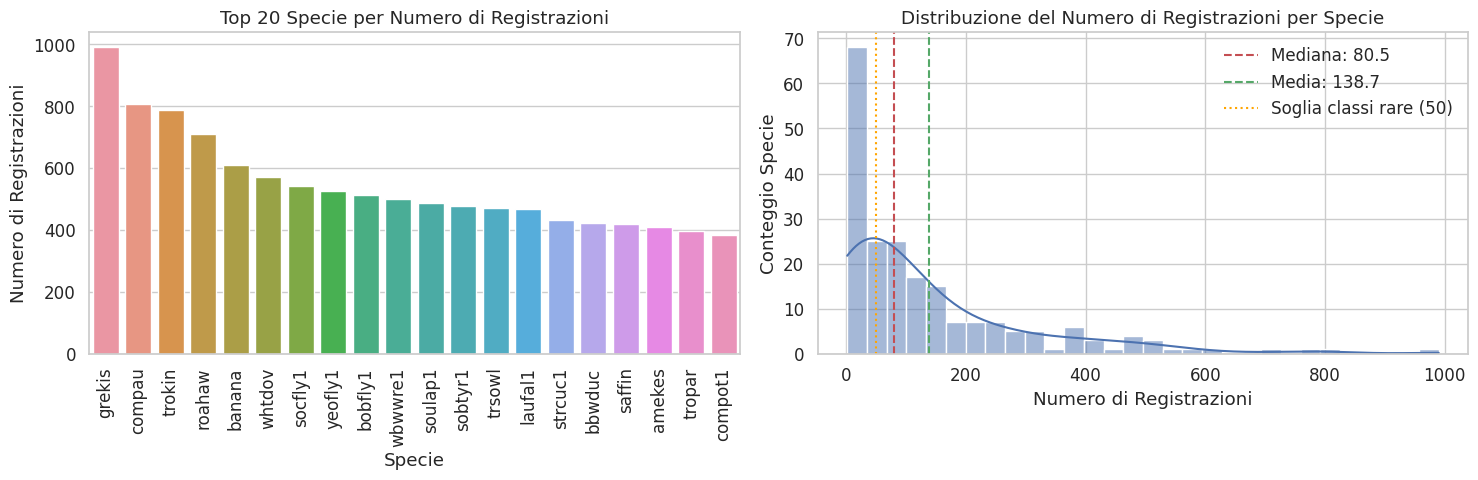


Indice di Gini per la distribuzione delle specie: 0.5895
Questo indica un moderato livello di sbilanciamento nel dataset.

=== Analisi dei Rating per Classi Rare (<50 esempi) ===
Numero di classi rare: 78 su 206 totali (37.9%)


<Figure size 1200x600 with 0 Axes>

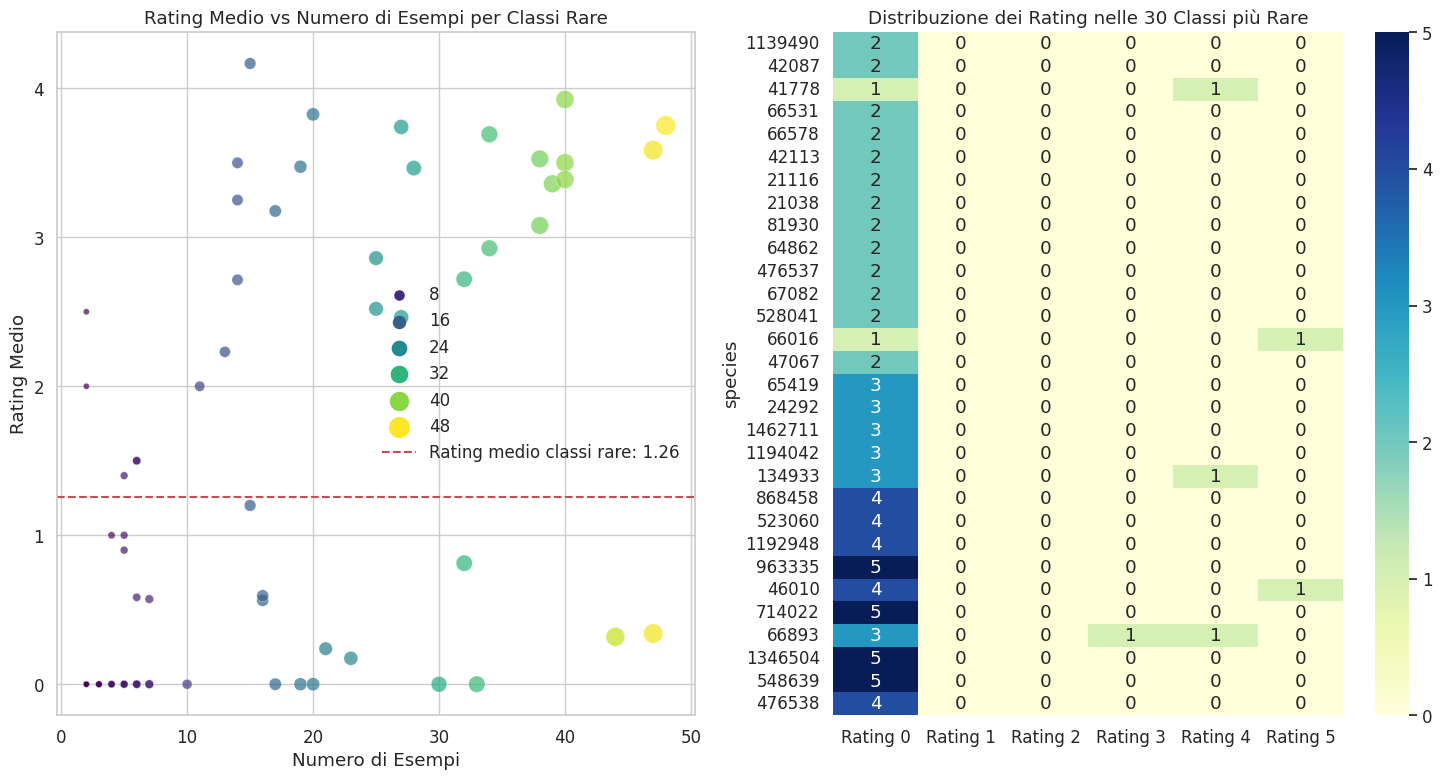


Statistiche sui rating per le classi rare:
- Rating medio complessivo: 1.26
- Percentuale di registrazioni senza rating (0): 44.6%

Classi estremamente rare (≤ 5 esempi): 30
Dettaglio delle registrazioni per le classi estremamente rare:
- 1346504: 5 esempi, ratings: [0.0, 0.0, 0.0, 0.0, 0.0]
- 548639: 5 esempi, ratings: [0.0, 0.0, 0.0, 0.0, 0.0]
- 476538: 5 esempi, ratings: [4.5, 0.0, 0.0, 0.0, 0.0]
- 963335: 5 esempi, ratings: [0.0, 0.0, 0.0, 0.0, 0.0]
- 66893: 5 esempi, ratings: [4.0, 3.0, 0.0, 0.0, 0.0]
- 714022: 5 esempi, ratings: [0.0, 0.0, 0.0, 0.0, 0.0]
- 46010: 5 esempi, ratings: [5.0, 0.0, 0.0, 0.0, 0.0]
- 134933: 4 esempi, ratings: [4.0, 0.0, 0.0, 0.0]
- 1192948: 4 esempi, ratings: [0.0, 0.0, 0.0, 0.0]
- 868458: 4 esempi, ratings: [0.0, 0.0, 0.0, 0.0]
- 523060: 4 esempi, ratings: [0.0, 0.0, 0.0, 0.0]
- 65419: 3 esempi, ratings: [0.0, 0.0, 0.0]
- 1194042: 3 esempi, ratings: [0.0, 0.0, 0.0]
- 1462711: 3 esempi, ratings: [0.0, 0.0, 0.0]
- 24292: 3 esempi, ratings: [0.0, 0.0, 0.

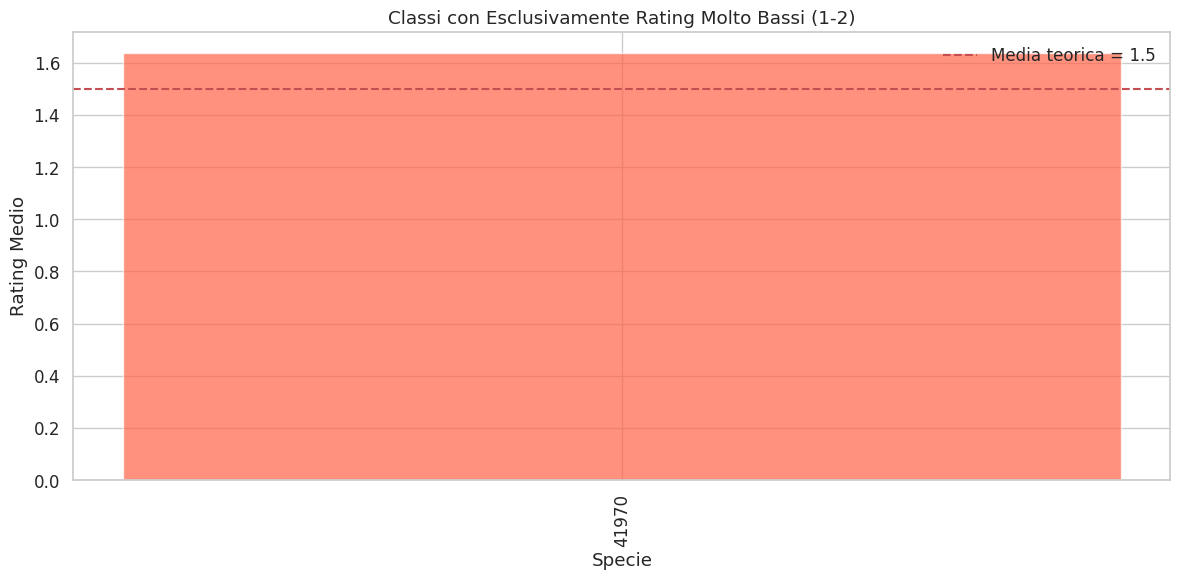


Dettagli delle prime 10 classi con solo rating molto bassi:
- 41970: 15 clip, rating medio: 1.64, ratings: [1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

Sovrapposizione con classi rare (<50 esempi): 1 classi
Le classi rare che hanno solo rating molto bassi: ['41970']

=== Conclusioni dall'Analisi delle Classi Rare ===
1. Abbiamo 78 classi rare (<50 esempi)
2. Di queste, 30 hanno 5 o meno esempi
3. La qualità delle registrazioni (rating) è un fattore critico per le classi rare
4. Le classi estremamente rare richiedono tecniche speciali (data augmentation, few-shot learning)


In [10]:
# Configurazione stile visualizzazioni
plt.style.use('seaborn-whitegrid')
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = [12, 6]

print("=== Statistiche di base del dataset ===")
print(f"Numero totale di registrazioni: {len(train_df)}")
print(f"Numero di specie uniche nel dataset: {len(all_species)}")
print(f"Campi disponibili nei metadati: {train_df.columns.tolist()}")

# Verifichiamo i dati mancanti
missing_data = train_df.isnull().sum()
print("\n=== Valori mancanti ===")
print(missing_data[missing_data > 0])

# 1. Distribuzione delle specie nel dataset (visualizzazione migliorata)
print("\n=== Analisi delle Specie ===")
primary_species_count = train_df['primary_label'].value_counts()

# Plot combinato: distribuzione delle specie con evidenza delle classi rare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# A sinistra: top 20 specie più rappresentate
sns.barplot(x=primary_species_count.head(20).index, y=primary_species_count.head(20).values, ax=ax1)
ax1.set_title('Top 20 Specie per Numero di Registrazioni')
ax1.set_xlabel('Specie')
ax1.set_ylabel('Numero di Registrazioni')
ax1.tick_params(axis='x', rotation=90)

# A destra: distribuzione del numero di esempi per specie
sns.histplot(primary_species_count, bins=30, kde=True, ax=ax2)
ax2.set_title('Distribuzione del Numero di Registrazioni per Specie')
ax2.set_xlabel('Numero di Registrazioni')
ax2.set_ylabel('Conteggio Specie')
ax2.axvline(x=primary_species_count.median(), color='r', linestyle='--', 
            label=f'Mediana: {primary_species_count.median()}')
ax2.axvline(x=primary_species_count.mean(), color='g', linestyle='--', 
            label=f'Media: {primary_species_count.mean():.1f}')
ax2.axvline(x=50, color='orange', linestyle=':', label='Soglia classi rare (50)')
ax2.legend()

plt.tight_layout()
plt.show()

# Calcolo dell'indice di Gini per misurare lo sbilanciamento
def gini_coefficient(x):
    x = np.sort(x)
    n = len(x)
    index = np.arange(1, n+1)
    return (np.sum((2*index - n - 1) * x)) / (n * np.sum(x))

gini = gini_coefficient(primary_species_count.values)
print(f"\nIndice di Gini per la distribuzione delle specie: {gini:.4f}")
print(f"Questo indica {'un alto' if gini > 0.6 else 'un moderato' if gini > 0.3 else 'un basso'} livello di sbilanciamento nel dataset.")

# 2. NUOVA ANALISI: Rating per le classi con pochi esempi
# Definisco la soglia per le classi rare (< 50 esempi)
RARE_CLASS_THRESHOLD = 50
rare_species = primary_species_count[primary_species_count < RARE_CLASS_THRESHOLD].index.tolist()
print(f"\n=== Analisi dei Rating per Classi Rare (<{RARE_CLASS_THRESHOLD} esempi) ===")
print(f"Numero di classi rare: {len(rare_species)} su {len(all_species)} totali ({len(rare_species)/len(all_species):.1%})")

# Raccolgo i dati sui rating per le classi rare
rare_class_ratings = []
for species in rare_species:
    species_df = train_df[train_df['primary_label'] == species]
    ratings = species_df['rating'].fillna(0).tolist()  # Sostituisco NaN con 0 (nessun rating)
    
    # Statistiche per questa specie
    rare_class_ratings.append({
        'species': species,
        'count': len(species_df),
        'avg_rating': np.mean(ratings),
        'ratings': ratings,
        'rating_counts': {r: ratings.count(r) for r in set(ratings)}
    })

# Creo DataFrame per analisi
rare_ratings_df = pd.DataFrame(rare_class_ratings)
rare_ratings_df = rare_ratings_df.sort_values('count')

# Visualizzazione: Rating medi vs Conteggio per le classi rare
plt.figure(figsize=(12, 6))

# Heatmap: distribuzione dei rating per classi rare
n_rare_to_show = min(30, len(rare_ratings_df))  # Mostra max 30 classi per leggibilità
rare_sample = rare_ratings_df.head(n_rare_to_show)

# Preparo i dati per la heatmap
heatmap_data = []
rating_values = [0, 1, 2, 3, 4, 5]  # Tutti i possibili rating
for _, row in rare_sample.iterrows():
    species_data = [row['species'], row['count']]
    for rating in rating_values:
        species_data.append(row['rating_counts'].get(rating, 0))
    heatmap_data.append(species_data)

# Creo DataFrame per la heatmap
heatmap_df = pd.DataFrame(
    heatmap_data, 
    columns=['species', 'count'] + [f'rating_{r}' for r in rating_values]
)

# Plot combinato con scatter plot e heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Scatter plot: rating medio vs numero esempi
sns.scatterplot(
    x='count', 
    y='avg_rating', 
    data=rare_ratings_df, 
    ax=ax1, 
    alpha=0.7,
    hue='count',
    palette='viridis',
    size='count',
    sizes=(20, 200)
)
ax1.set_title('Rating Medio vs Numero di Esempi per Classi Rare')
ax1.set_xlabel('Numero di Esempi')
ax1.set_ylabel('Rating Medio')
ax1.grid(True)

# Mostra statistiche
avg_rating_rare = rare_ratings_df['avg_rating'].mean()
ax1.axhline(y=avg_rating_rare, color='r', linestyle='--', 
           label=f'Rating medio classi rare: {avg_rating_rare:.2f}')
ax1.legend()

# Heatmap: distribuzione dei rating per le classi più rare
pivot_data = pd.DataFrame({
    'species': heatmap_df['species'],
    'Rating 0': heatmap_df['rating_0'],
    'Rating 1': heatmap_df['rating_1'],
    'Rating 2': heatmap_df['rating_2'],
    'Rating 3': heatmap_df['rating_3'],
    'Rating 4': heatmap_df['rating_4'],
    'Rating 5': heatmap_df['rating_5'],
}).set_index('species')

sns.heatmap(pivot_data, cmap="YlGnBu", annot=True, fmt='g', ax=ax2)
ax2.set_title(f'Distribuzione dei Rating nelle {n_rare_to_show} Classi più Rare')

plt.tight_layout()
plt.show()

# Statistiche aggregate sui rating per le classi rare
print("\nStatistiche sui rating per le classi rare:")
print(f"- Rating medio complessivo: {rare_ratings_df['avg_rating'].mean():.2f}")
print(f"- Percentuale di registrazioni senza rating (0): {sum(r['rating_counts'].get(0, 0) for r in rare_class_ratings) / sum(r['count'] for r in rare_class_ratings):.1%}")

# Analisi delle classi estremamente rare (≤ 5 esempi)
very_rare_species = primary_species_count[primary_species_count <= 5].index.tolist()
print(f"\nClassi estremamente rare (≤ 5 esempi): {len(very_rare_species)}")

very_rare_df = train_df[train_df['primary_label'].isin(very_rare_species)]
print("Dettaglio delle registrazioni per le classi estremamente rare:")
for species in very_rare_species:
    species_data = train_df[train_df['primary_label'] == species]
    ratings = species_data['rating'].fillna(0).tolist()
    print(f"- {species}: {len(species_data)} esempi, ratings: {ratings}")


# Identificazione delle classi con solo rating molto bassi (1-2)
print("\n=== Analisi delle Classi con SOLO Rating Molto Bassi (1-2) ===")

# Funzione per verificare se una specie ha esclusivamente rating tra 1-2
def has_only_low_ratings(species_ratings):
    valid_ratings = [r for r in species_ratings if pd.notna(r) and r != 0]  # Escludi NaN e rating=0
    if not valid_ratings:  # Se non ci sono rating validi
        return False
    return all(1 <= r <= 2 for r in valid_ratings)  # Modificato: ora solo 1-2

# Raggruppa per specie e analizza
low_rating_species = []
for species, group in train_df.groupby('primary_label'):
    ratings = group['rating'].tolist()
    if has_only_low_ratings(ratings):
        low_rating_species.append({
            'species': species,
            'count': len(ratings),
            'avg_rating': np.nanmean([r for r in ratings if pd.notna(r) and r != 0]),
            'ratings': sorted([r for r in ratings if pd.notna(r) and r != 0])
        })

# Crea DataFrame e visualizza risultati
if low_rating_species:
    low_rating_df = pd.DataFrame(low_rating_species).sort_values('count', ascending=False)
    
    print(f"Trovate {len(low_rating_species)} classi con SOLO rating molto bassi (1-2):")
    
    # Visualizzazione
    plt.figure(figsize=(12, 6))
    plt.bar(low_rating_df['species'], low_rating_df['avg_rating'], alpha=0.7, color='tomato')
    plt.axhline(y=1.5, color='r', linestyle='--', label='Media teorica = 1.5')
    plt.title('Classi con Esclusivamente Rating Molto Bassi (1-2)')
    plt.xlabel('Specie')
    plt.ylabel('Rating Medio')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Mostra dettagli delle prime 10 classi
    print("\nDettagli delle prime 10 classi con solo rating molto bassi:")
    for i, row in low_rating_df.head(10).iterrows():
        print(f"- {row['species']}: {row['count']} clip, rating medio: {row['avg_rating']:.2f}, ratings: {row['ratings']}")
    
    # Cerca sovrapposizione con classi rare
    overlap = [s for s in low_rating_df['species'] if s in rare_species]
    print(f"\nSovrapposizione con classi rare (<{RARE_CLASS_THRESHOLD} esempi): {len(overlap)} classi")
    if overlap:
        print(f"Le classi rare che hanno solo rating molto bassi: {overlap[:10]}{'...' if len(overlap) > 10 else ''}")
else:
    print("Nessuna classe ha esclusivamente rating da 1 a 2.")

print("\n=== Conclusioni dall'Analisi delle Classi Rare ===")
print(f"1. Abbiamo {len(rare_species)} classi rare (<{RARE_CLASS_THRESHOLD} esempi)")
print(f"2. Di queste, {len(very_rare_species)} hanno 5 o meno esempi")
print("3. La qualità delle registrazioni (rating) è un fattore critico per le classi rare")
print("4. Le classi estremamente rare richiedono tecniche speciali (data augmentation, few-shot learning)")

## Data Augmentation: Implementazione delle Tecniche dei Vincitori

In questa sezione implementiamo le tre tecniche di data augmentation che hanno contribuito significativamente alle performance dei vincitori:
1. **Random Segment Selection** - Estrae segmenti casuali dalle registrazioni audio
2. **XY Masking** - Applica maschere casuali sugli assi tempo e frequenza degli spettrogrammi Mel
3. **Horizontal CutMix** - Combina parti di spettrogrammi da diverse registrazioni

La classe `AudioAugmentations` gestisce tutte queste trasformazioni in modo unificato.

In [11]:
class AudioAugmentations:
    def __init__(self, p_random_segment=0.5, p_xy_mask=0.5, p_horizontal_cutmix=0.25):
        """
        Inizializza le trasformazioni per data augmentation audio.
        
        Args:
            p_random_segment: Probabilità di utilizzare un segmento casuale
            p_xy_mask: Probabilità di applicare il mascheramento XY
            p_horizontal_cutmix: Probabilità di applicare horizontal cutmix
        """
        self.p_random_segment = p_random_segment
        self.p_xy_mask = p_xy_mask
        self.p_horizontal_cutmix = p_horizontal_cutmix
    
    def apply_xy_masking(self, spec):
        """Applica maschere casuali sull'asse X (tempo) e Y (frequenza) allo spettrogramma"""
        mask = spec.clone()
        
        # Determina la dimensionalità del tensore
        if len(mask.shape) == 3:  # [channels, height, width]
            channels, height, width = mask.shape
        elif len(mask.shape) == 4:  # [batch, channels, height, width]
            _, channels, height, width = mask.shape
        else:
            raise ValueError(f"Forma dello spettrogramma non supportata: {mask.shape}")
        
        # Masking temporale (asse X)
        if np.random.random() < self.p_xy_mask:
            mask_width = int(width * np.random.uniform(0.1, 0.2))  # 10-20% width
            mask_start = np.random.randint(0, width - mask_width)
            mask[..., mask_start:mask_start+mask_width] = 0
        
        # Masking frequenziale (asse Y)
        if np.random.random() < self.p_xy_mask:
            mask_height = int(height * np.random.uniform(0.1, 0.2))  # 10-20% height
            mask_start = np.random.randint(0, height - mask_height)
            
            # Adatta l'indicizzazione in base alla dimensionalità
            if len(mask.shape) == 3:  # [channels, height, width]
                mask[:, mask_start:mask_start+mask_height, :] = 0
            else:  # [batch, channels, height, width]
                mask[:, :, mask_start:mask_start+mask_height, :] = 0
            
        return mask

In [12]:
import torch.nn.functional as F

class SpectrogramImageAugmentations:
    def __init__(self, p_random_erasing=0.3, p_time_mask=0.5, p_freq_mask=0.5):
        """
        Augmentations che trattano gli spettrogrammi come immagini.
        
        Args:
            p_random_erasing: Probabilità di applicare Random Erasing
            p_time_mask: Probabilità di applicare Time Masking
            p_freq_mask: Probabilità di applicare Frequency Masking
        """
        self.p_random_erasing = p_random_erasing
        self.p_time_mask = p_time_mask
        self.p_freq_mask = p_freq_mask
    
    def random_erasing(self, spec, scale=(0.02, 0.1), ratio=(0.3, 3.3)):
        """
        Applica Random Erasing come nelle immagini.
        Rimuove rettangoli casuali dallo spettrogramma.
        """
        if np.random.random() > self.p_random_erasing:
            return spec
            
        spec = spec.clone()
        
        # Ottieni dimensioni [C, H, W]
        if len(spec.shape) == 3:
            C, H, W = spec.shape
        else:
            raise ValueError(f"Forma spettrogramma non supportata: {spec.shape}")
        
        # Calcola area del rettangolo da cancellare
        area = H * W
        target_area = np.random.uniform(scale[0], scale[1]) * area
        aspect_ratio = np.random.uniform(ratio[0], ratio[1])
        
        # Calcola dimensioni del rettangolo
        h = int(round(np.sqrt(target_area * aspect_ratio)))
        w = int(round(np.sqrt(target_area / aspect_ratio)))
        
        # Assicurati che le dimensioni siano valide
        if w < W and h < H:
            x1 = np.random.randint(0, W - w)
            y1 = np.random.randint(0, H - h)
            
            # Cancella il rettangolo (imposta a 0 o valore medio)
            spec[:, y1:y1+h, x1:x1+w] = 0
            
        return spec
    
    def time_frequency_masking(self, spec):
        """
        Applica Time e Frequency Masking separatamente.
        Più aggressivo del semplice XY masking.
        """
        spec = spec.clone()
        
        if len(spec.shape) == 3:
            C, H, W = spec.shape
        else:
            raise ValueError(f"Forma spettrogramma non supportata: {spec.shape}")
        
        # Time Masking (asse temporale)
        if np.random.random() < self.p_time_mask:
            # Maschera 10-25% dell'asse temporale
            mask_width = int(W * np.random.uniform(0.1, 0.25))
            mask_start = np.random.randint(0, max(1, W - mask_width))
            spec[:, :, mask_start:mask_start + mask_width] = 0
        
        # Frequency Masking (asse frequenziale)
        if np.random.random() < self.p_freq_mask:
            # Maschera 10-20% dell'asse frequenziale
            mask_height = int(H * np.random.uniform(0.1, 0.2))
            mask_start = np.random.randint(0, max(1, H - mask_height))
            spec[:, mask_start:mask_start + mask_height, :] = 0
            
        return spec
    
    def apply_all(self, spec):
        """Applica tutte le augmentations in sequenza"""
        # Prima Random Erasing
        spec = self.random_erasing(spec)
        
        # Poi Time/Frequency Masking
        spec = self.time_frequency_masking(spec)
        
        return spec

### Horizontal CutMix: Implementazione della Funzione di Collate

Questa funzione personalizzata viene utilizzata nel DataLoader per implementare l'Horizontal CutMix,
che combina sezioni temporali di spettrogrammi diversi all'interno dello stesso batch.
Le etichette vengono miscelate proporzionalmente alla quantità di dati combinati.

In [13]:
def mixup_cutmix_collate(batch, p_mixup=1.0, p_cutmix=0.25, alpha=0.2):
    """
    Collate function che applica SEMPRE Mixup (p=1.0) e occasionalmente CutMix.
    
    Args:
        batch: Lista di tuple (input, target)
        p_mixup: Probabilità di applicare mixup (1.0 = sempre)
        p_cutmix: Probabilità di applicare cutmix invece di mixup
        alpha: Parametro per la distribuzione Beta
    
    Returns:
        tuple: (inputs_batch, targets_batch)
    """
    inputs = []
    targets = []
    
    # Estrae input e target dal batch
    for input_tensor, target_tensor in batch:
        inputs.append(input_tensor)
        targets.append(target_tensor)
    
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    batch_size = len(inputs)
    
    if batch_size > 1 and np.random.rand() < p_mixup:
        # Decide se fare CutMix o Mixup normale
        if np.random.rand() < p_cutmix:
            # === CUTMIX (come prima) ===
            for i in range(batch_size):
                j = np.random.randint(0, batch_size)
                if i != j:
                    width = inputs.shape[3]
                    cut_point = np.random.randint(int(width * 0.25), int(width * 0.75))
                    mix_ratio = cut_point / width
                    inputs[i, :, :, :cut_point] = inputs[j, :, :, :cut_point]
                    targets[i] = targets[i] * (1 - mix_ratio) + targets[j] * mix_ratio
        else:
            # === MIXUP NORMALE ===
            # Genera lambda dalla distribuzione Beta
            lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
            
            # Permuta gli indici per il mixing
            indices = torch.randperm(batch_size)
            
            # Mix degli input
            inputs = lam * inputs + (1 - lam) * inputs[indices]
            
            # Mix dei target
            targets = lam * targets + (1 - lam) * targets[indices]
    
    return inputs, targets

## Caricamento e pre-processing

## Preprocessing Audio con Supporto per Data Augmentation

La funzione di caricamento audio è stata modificata per supportare due modalità di estrazione:
- **Posizionale** - Estrazione da punti specifici nella registrazione ('start', 'center', 'end')
- **Casuale** - Estrazione di un segmento casuale quando `random_segment=True`

Questa implementazione permette di applicare la tecnica di Random Segment Selection come parte della data augmentation.

In [14]:
def load_and_preprocess_audio_torch(file_path, target_sr=config.SR, duration=config.DURATION, 
                                    segment_position='center', random_segment=False):
    """
    Carica un file audio, estrae un segmento e lo converte in spettrogramma Mel.
    Ottimizzata per segmenti lunghi (15s).
    """
    try:
        # Carica il file audio con torchaudio
        waveform, sr = torchaudio.load(file_path)
        
        # Converti a mono se necessario
        if waveform.shape[0] > 1:
            waveform = waveform[0:1]
        
        # Ricampiona se necessario
        if sr != target_sr:
            resampler = T.Resample(sr, target_sr)
            waveform = resampler(waveform)
        
        # Calcola la lunghezza target in campioni
        target_len = int(target_sr * duration)
        total_len = waveform.shape[1]
        
        # Gestisci clip troppo corte - strategia migliorata
        if total_len < target_len:
            if total_len < target_len / 3:
                # Per file molto corti, ripeti l'audio
                n_repeat = (target_len // total_len) + 1
                waveform = waveform.repeat(1, n_repeat)
            else:
                # Per file moderatamente corti, usa padding con silenzio
                padding = target_len - total_len
                waveform = torch.nn.functional.pad(waveform, (0, padding), mode='constant', value=0)
            total_len = waveform.shape[1]
        
        # Seleziona il segmento - ora sempre casuale
        if random_segment or segment_position is None:
            # Estrai segmento casuale
            max_start_idx = total_len - target_len
            if max_start_idx <= 0:
                start_idx = 0
            else:
                start_idx = torch.randint(0, max_start_idx, (1,)).item()
        else:
            # Supporta ancora le posizioni predefinite per compatibilità
            if segment_position == 'start':
                start_idx = int(total_len * 0.1)  # 10% dall'inizio
            elif segment_position == 'end':
                start_idx = max(0, total_len - target_len - int(total_len * 0.1))  # 10% dalla fine
            else:  # 'center' (default)
                start_idx = max(0, int(total_len / 2 - target_len / 2))
        
        # Estrai il segmento
        waveform = waveform[:, start_idx:start_idx + target_len]
        
        # Padda se necessario (nel caso di start_idx + target_len > total_len)
        if waveform.shape[1] < target_len:
            padding = target_len - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        
        # Applica la trasformazione Mel
        mel_spectrogram = mel_transform(waveform)
        
        # Converti in scala dB e normalizza
        log_mel_spec = amplitude_to_db(mel_spectrogram)
        
        return log_mel_spec
        
    except Exception as e:
        print(f"Errore nell'elaborazione di {file_path}: {e}")
        # Crea uno spettrogramma vuoto
        time_steps = int(target_sr * duration / config.HOP_LENGTH) + 1
        return torch.zeros((1, config.N_MELS, time_steps), dtype=torch.float32)

## 5. Dataset PyTorch per Dati Audio

## Dataset PyTorch con Supporto Integrato per Data Augmentation

Implementiamo due classi di dataset:
- `RandomSegmentBirdDataset` 
  - Estrae segmenti randomici di 15 secondi in base alla durata delle registrazioni
  - Applica le tecniche di data augmentation durante il caricamento

### RandomSegmentBirdDataset

In [15]:
class RandomSegmentBirdDataset(Dataset):
    def __init__(self, df, audio_dir, labels_one_hot, transform=None, 
                 augmentations=None, image_augmentations=None):
        """Dataset con caricamento LAZY degli spettrogrammi"""
        self.df = df
        self.audio_dir = audio_dir
        self.labels = labels_one_hot
        self.transform = transform
        self.augmentations = augmentations
        self.image_augmentations = image_augmentations
        
        print("Dataset con LAZY loading inizializzato...")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Ottieni il record dal DataFrame
        row = self.df.iloc[idx]
        filename = row['filename']
        file_path = os.path.join(self.audio_dir, filename)
        
        if not os.path.exists(file_path):
            print(f"Attenzione: File non trovato in {file_path}.")
            time_steps = int(config.SR * config.DURATION / config.HOP_LENGTH) + 1
            dummy_spec = torch.zeros((1, config.N_MELS, time_steps), dtype=torch.float32)
            dummy_label = torch.zeros(config.N_CLASSES, dtype=torch.float32)
            return dummy_spec, dummy_label
        
        # ⚠️ CARICA SOLO AL MOMENTO DELL'USO - NON PRIMA!
        try:
            # Carica il file audio con torchaudio direttamente qui
            waveform, sr = torchaudio.load(file_path)
            
            # Converti a mono se necessario
            if waveform.shape[0] > 1:
                waveform = waveform[0:1]
            
            # Ricampiona se necessario
            if sr != config.SR:
                resampler = T.Resample(sr, config.SR)
                waveform = resampler(waveform)
            
            # Calcola la lunghezza target in campioni
            target_len = int(config.SR * config.DURATION)
            total_len = waveform.shape[1]
            
            # Estrai segmento casuale
            if total_len > target_len:
                max_start_idx = total_len - target_len
                start_idx = torch.randint(0, max_start_idx, (1,)).item()
                waveform = waveform[:, start_idx:start_idx + target_len]
            elif total_len < target_len:
                # Padda se necessario
                padding = target_len - total_len
                waveform = torch.nn.functional.pad(waveform, (0, padding))
            
            # Calcola spettrogramma MEL
            mel_spectrogram = mel_transform(waveform)
            log_mel_spec = amplitude_to_db(mel_spectrogram)
            
        except Exception as e:
            print(f"Errore nel caricamento di {file_path}: {e}")
            time_steps = int(config.SR * config.DURATION / config.HOP_LENGTH) + 1
            log_mel_spec = torch.zeros((1, config.N_MELS, time_steps), dtype=torch.float32)
        
        # Applica augmentations solo se richieste (e molto leggere)
        if self.augmentations and np.random.random() < 0.1:  # Solo 10%
            log_mel_spec = self.augmentations.apply_xy_masking(log_mel_spec)
        
        # Ottieni le etichette
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return log_mel_spec, label_tensor

### Creazione dataset e dataloader con RandomSegmentBirdDataset

### Creazione dei DataLoader con Augmentation

In questa sezione:
1. Applichiamo il bilanciamento strategico al dataset di training
2. Creiamo l'istanza di AudioAugmentations con le probabilità ottimali
3. Configuriamo i dataloader con le funzioni di collate personalizzate
4. Analizziamo la distribuzione dei segmenti nel dataset risultante

In [16]:
# Applica il bilanciamento strategico solo al dataset di training
print("\n=== Bilanciamento Strategico del Dataset di Training ===")
X_train_df_balanced, y_train_one_hot_balanced = create_balanced_dataset_df(
    X_train_df, 
    y_train_one_hot,
    abundant_class_threshold=150,
    remove_percentage=0.4
)

# === NUOVE AUGMENTATIONS ===
# Crea augmentations audio originali
audio_augmentations = AudioAugmentations(
    p_random_segment=1.0,  # Sempre segmenti casuali
    p_xy_mask=0.3,         # Ridotto perché abbiamo anche le image augmentations
    p_horizontal_cutmix=0.0  # Disabilitato qui, lo facciamo nel collate
)

# Crea augmentations come immagini (NUOVO!)
image_augmentations = SpectrogramImageAugmentations(
    p_random_erasing=0.3,   # Random Erasing al 30%
    p_time_mask=0.5,        # Time Masking al 50%
    p_freq_mask=0.5         # Frequency Masking al 50%
)

# Per validation: solo segmenti casuali, nessuna augmentation
val_augmentations = AudioAugmentations(
    p_random_segment=1.0,
    p_xy_mask=0.0,
    p_horizontal_cutmix=0.0
)

# Creiamo i dataset con le NUOVE augmentations
print("Creazione dataset di training con augmentations come immagini...")
train_dataset = RandomSegmentBirdDataset(
    X_train_df_balanced, 
    config.TRAIN_AUDIO_DIR, 
    y_train_one_hot_balanced,
    augmentations=audio_augmentations,
    image_augmentations=image_augmentations  # NUOVO!
)

print("Creazione dataset di validation...")
val_dataset = RandomSegmentBirdDataset(
    X_val_df, 
    config.TRAIN_AUDIO_DIR, 
    y_val_one_hot,
    augmentations=val_augmentations,
    image_augmentations=None  # Nessuna augmentation per validation
)

# === DATALOADER CON MIXUP SEMPRE ATTIVO ===
# Training con Mixup + CutMix
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True,
    num_workers=config.NUM_WORKERS, 
    pin_memory=True,
    collate_fn=lambda batch: mixup_cutmix_collate(
        batch, 
        p_mixup=1.0,      # SEMPRE Mixup (come richiesto dai vincitori)
        p_cutmix=0.25,    # 25% delle volte CutMix invece di Mixup normale
        alpha=0.2         # Parametro Beta per Mixup
    )
)

# Validation senza augmentations
val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False,
    num_workers=config.NUM_WORKERS, 
    pin_memory=True
)

print(f"Numero di batch di training per epoca: {len(train_loader)}")
print(f"Numero di batch di validation per epoca: {len(val_loader)}")
print("=== AUGMENTATIONS ATTIVE ===")
print("✅ Random Segment Selection (100%)")
print("✅ Random Erasing (30%)")
print("✅ Time/Frequency Masking (50%)")
print("✅ Mixup (100% - sempre attivo)")
print("✅ CutMix (25% delle volte invece di Mixup)")


=== Bilanciamento Strategico del Dataset di Training ===
Classi identificate come abbondanti (>150 esempi): 49
Totale esempi rimossi: 707 (3.1% del dataset originale)
Dimensione dataset originale: 22851
Dimensione dataset bilanciato: 22144

Classi con maggior numero di esempi rimossi:
- roahaw: 34 rimossi, 551/585 rimanenti (94.2%)
- banana: 26 rimossi, 471/497 rimanenti (94.8%)
- grekis: 25 rimossi, 762/787 rimanenti (96.8%)
- compau: 25 rimossi, 607/632 rimanenti (96.0%)
- littin1: 23 rimossi, 247/270 rimanenti (91.5%)
Creazione dataset di training con augmentations come immagini...
Dataset con LAZY loading inizializzato...
Creazione dataset di validation...
Dataset con LAZY loading inizializzato...
Numero di batch di training per epoca: 231
Numero di batch di validation per epoca: 60
=== AUGMENTATIONS ATTIVE ===
✅ Random Segment Selection (100%)
✅ Random Erasing (30%)
✅ Time/Frequency Masking (50%)
✅ Mixup (100% - sempre attivo)
✅ CutMix (25% delle volte invece di Mixup)


## 6. Definizione del Modello CNN

## Modello EfficientNet con Head Personalizzata

Implementiamo un modello basato su EfficientNet-B0 preaddestrato, con:
- Supporto per input a singolo canale (spettrogrammi Mel)
- Testa di classificazione personalizzata con dropout e normalizzazione batch
- Parametri differenziati per l'ottimizzazione
- Gestione automatica dei checkpoint e dei pesi preaddestrati

In [17]:
class WeightedFocalBCELoss(nn.Module):
    def __init__(self, class_counts, gamma=2, alpha_rare=3.0, alpha_common=0.5):
        """
        Focal Loss che penalizza di più gli errori sulle classi rare.
        
        Args:
            class_counts: Dict con {specie: numero_esempi} per calcolare i pesi
            gamma: Parametro per Focal Loss (default: 2)
            alpha_rare: Peso per classi rare (default: 3.0)
            alpha_common: Peso per classi comuni (default: 0.5)
        """
        super().__init__()
        self.gamma = gamma
        
        # Calcola pesi per classe basati sulla frequenza inversa
        total_samples = sum(class_counts.values())
        self.class_weights = {}
        
        for species, count in class_counts.items():
            # Frequenza inversa con smoothing
            frequency = count / total_samples
            
            # Classi rare (< 1% del dataset) → peso alto
            if frequency < 0.01:
                weight = alpha_rare
            # Classi comuni (> 5% del dataset) → peso basso  
            elif frequency > 0.05:
                weight = alpha_common
            # Classi medie → peso intermedio
            else:
                weight = 1.0 / (frequency + 0.001)  # +smoothing
                weight = min(weight, 2.0)  # Cap massimo
        
            self.class_weights[species] = weight
        
        print(f"Pesi calcolati: rare={alpha_rare}, comuni={alpha_common}")
        
        # Converte in tensore per GPU
        weight_tensor = torch.tensor([self.class_weights.get(species, 1.0) 
                                    for species in sorted(class_counts.keys())], dtype=torch.float32)
        self.register_buffer('alpha_weights', weight_tensor)
    
    def forward(self, inputs, targets):
        """
        Forward pass con pesi per classe.
        
        Args:
            inputs: [batch, num_classes] - logits del modello
            targets: [batch, num_classes] - one-hot targets
        """
        # Assicurati che i tensori siano sullo stesso device
        device = inputs.device
        targets = targets.to(device)
        
        # BCE Loss base
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        
        # Probabilità predette
        pt = torch.exp(-bce_loss)
        
        # Componente Focal (riduce peso degli esempi facili)
        focal_weight = (1 - pt) ** self.gamma
        
        # CORRETTO: Applica pesi per classe (assicurati che sia sullo stesso device)
        alpha_weights = self.alpha_weights.to(device).unsqueeze(0)  # [1, num_classes] e stesso device
        weighted_focal_loss = alpha_weights * focal_weight * bce_loss
        
        # Media solo sui target positivi (multi-label)
        positive_mask = targets > 0
        if positive_mask.sum() > 0:
            return weighted_focal_loss[positive_mask].mean()
        else:
            return weighted_focal_loss.mean()

In [18]:
class EfficientNetBirdClassifier(nn.Module):
    def __init__(self, num_classes=config.N_CLASSES, pretrained=True, model_name='efficientnet_b0'):
        super(EfficientNetBirdClassifier, self).__init__()
        
        # Tenta di caricare il modello con pesi pre-addestrati, gestendo fallimenti di connessione
        try:
            if pretrained:
                print(f"Tentativo di caricare {model_name} con pesi pre-addestrati...")
                self.efficientnet = timm.create_model(
                    model_name,
                    pretrained=True,
                    num_classes=0  # Rimuovi il classificatore originale
                )
                print("Modello caricato con successo con pesi pre-addestrati.")
            else:
                # Se pretrained=False, non tentare di scaricare i pesi
                self.efficientnet = timm.create_model(
                    model_name,
                    pretrained=False,  # CORRETTO: ora è False
                    num_classes=0  # Rimuovi il classificatore originale
                )
                print("Modello inizializzato senza pesi pre-addestrati (modalità offline).")
        except Exception as e:
            print(f"Errore nel caricamento dei pesi pre-addestrati: {e}")
            print("Inizializzazione del modello senza pesi pre-addestrati...")
            self.efficientnet = timm.create_model(
                model_name,
                pretrained=False,
                num_classes=0  # Rimuovi il classificatore originale
            )
        
        # Ottieni la dimensione dell'output del feature extractor
        if hasattr(self.efficientnet, 'num_features'):
            classifier_in_features = self.efficientnet.num_features
        elif hasattr(self.efficientnet, 'classifier'):
            classifier_in_features = self.efficientnet.classifier.in_features
        else:
            # Valore predefinito per EfficientNet-B0
            classifier_in_features = 1280
        
         # Sostituisci il classificatore semplice con una MLP con dropout
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),  # Primo dropout significativo
            nn.Linear(classifier_in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),  # Secondo dropout più leggero
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # Se l'input è un'immagine a 1 canale, replicala su 3 canali
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)
        
        # Passa l'input attraverso il backbone per ottenere le features
        features = self.efficientnet(x)
        
        # Passa le feature attraverso il classificatore
        output = self.classifier(features)
        
        return output

# Controlla se esiste un checkpoint precedente
has_previous_checkpoint = False
if config.environment == 'kaggle':
    latest_checkpoint = '/kaggle/working/checkpoints/latest_checkpoint.pth'
    has_previous_checkpoint = os.path.exists(latest_checkpoint)
elif config.environment == 'colab':
    drive_checkpoint = '/content/drive/MyDrive/birdclef_checkpoints/latest_checkpoint.pth'
    has_previous_checkpoint = os.path.exists(drive_checkpoint)
else:
    # Per ambienti locali
    local_checkpoint = os.path.join(config.OUTPUT_DIR, 'checkpoints', 'latest_checkpoint.pth')
    has_previous_checkpoint = os.path.exists(local_checkpoint)

# Inizializza il modello - usa pretrained=False se hai già un checkpoint
model = EfficientNetBirdClassifier(
    num_classes=config.N_CLASSES, 
    pretrained=not has_previous_checkpoint  # Scarica i pesi solo se non c'è già un checkpoint
).to(config.DEVICE)

# Definiamo ottimizzatore con learning rate differenziati
def get_optimizer(model, lr_base=5e-4, lr_head=1e-3):  # Ridotti significativamente
    # Parametri del corpo (pre-addestrati)
    backbone_params = [p for name, p in model.named_parameters() 
                      if 'classifier' not in name]
    
    # Parametri della testa (da addestrare da zero)
    classifier_params = [p for name, p in model.named_parameters() 
                      if 'classifier' in name]
    
    optimizer = optim.AdamW([
        {'params': backbone_params, 'lr': lr_base},  # Ridotto da 1e-3 a 5e-4
        {'params': classifier_params, 'lr': lr_head}  # Ridotto da 3e-3 a 1e-3
    ], weight_decay=3e-4)
    
    return optimizer

# Dopo aver caricato train_df, calcola le frequenze delle classi
primary_species_count = train_df['primary_label'].value_counts().to_dict()

# Sostituisci la loss function
criterion = WeightedFocalBCELoss(
    class_counts=primary_species_count,
    gamma=2,
    alpha_rare=3.0,    # Peso 3x per classi rare
    alpha_common=0.5   # Peso 0.5x per classi comuni
)

# Ottimizzatore con learning rate differenziati
optimizer = get_optimizer(model)

# Learning rate scheduler - aggiornato a CosineAnnealingLR come usato dai vincitori
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config.EPOCHS,  # Numero totale di epoche
    eta_min=1e-6  # Learning rate minimo
)

print(f"Modello EfficientNet-B0 (timm) caricato su {config.DEVICE}")
print(f"Numero di classi: {config.N_CLASSES}")
print(f"Parametri totali: {sum(p.numel() for p in model.parameters()):,}")

Tentativo di caricare efficientnet_b0 con pesi pre-addestrati...


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Modello caricato con successo con pesi pre-addestrati.
Pesi calcolati: rare=3.0, comuni=0.5
Modello EfficientNet-B0 (timm) caricato su cuda
Numero di classi: 206
Parametri totali: 4,770,122


## 7. Addestramento e Validazione del Modello

## Funzione di Training con Supporto per Checkpoint

La funzione di training implementa:
- Caricamento automatico dei checkpoint precedenti
- Early stopping basato sulle performance di validation
- Salvataggio periodico dei checkpoint e del miglior modello
- Supporto per scheduler di learning rate (CosineAnnealingLR)
- Visualizzazione delle curve di loss

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                epochs=config.EPOCHS, device=config.DEVICE, 
                model_save_path=None, model_load_path=None, patience=3,
                resume_training=True, scheduler=None):
    """
    Addestra il modello e valuta su validation set con supporto per checkpoint.
    
    Args:
        model: Modello PyTorch da addestrare
        train_loader: DataLoader per dati di training
        val_loader: DataLoader per dati di validation
        criterion: Funzione di loss
        optimizer: Ottimizzatore
        epochs: Numero di epoche di training
        device: Device per l'addestramento ('cuda' o 'cpu')
        model_save_path: Path dove salvare il modello addestrato
        model_load_path: Path da cui caricare un modello pre-addestrato
        patience: Numero di epoche senza miglioramento prima di terminare l'addestramento
        resume_training: Se True, riprende il training da un checkpoint (se disponibile)
        scheduler: Learning rate scheduler
        
    Returns:
        tuple: (train_losses, val_losses, total_training_time)
    """
    # Directory per i checkpoint in base all'ambiente
    checkpoint_dir = None
    drive_mounted = False
    
    # Configura la directory per i checkpoint a seconda dell'ambiente
    if config.environment == 'colab':
        try:
            from google.colab import drive
            # Controlla se il drive è già montato
            if not os.path.exists('/content/drive'):
                print("Montaggio di Google Drive...")
                drive.mount('/content/drive')
                print("Google Drive montato con successo.")
            
            # Crea directory per i checkpoint se non esiste
            checkpoint_dir = '/content/drive/MyDrive/birdclef_checkpoints'
            os.makedirs(checkpoint_dir, exist_ok=True)
            print(f"Directory per i checkpoint creata su Google Drive: {checkpoint_dir}")
            
            # Aggiorna il percorso di salvataggio per usare Google Drive
            if model_save_path:
                filename = os.path.basename(model_save_path)
                model_save_path = os.path.join(checkpoint_dir, filename)
                print(f"Il modello sarà salvato in: {model_save_path}")
            
            drive_mounted = True
        except ImportError:
            print("Errore: Non riesco ad accedere a Google Drive. Continuo senza persistenza.")
        except Exception as e:
            print(f"Errore durante il montaggio di Google Drive: {e}")
            print("Continuo senza persistenza su Drive.")
    elif config.environment == 'kaggle':
        # In Kaggle, usa la directory di working
        checkpoint_dir = '/kaggle/working/checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Directory per i checkpoint creata in Kaggle: {checkpoint_dir}")
    else:
        # In locale, usa la directory 'checkpoints' nell'OUTPUT_DIR
        checkpoint_dir = os.path.join(config.OUTPUT_DIR, 'checkpoints')
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Directory per i checkpoint creata in locale: {checkpoint_dir}")
    
    # Inizializzazione variabili
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    total_training_time = 0
    start_epoch = 0
    needs_training = True
    checkpoint_exists = False
    model_loaded = False
    
    # Verifica se esiste un modello pre-addestrato da caricare
    if model_load_path and os.path.exists(model_load_path):
        print(f"Modello trovato in {model_load_path}. Tentativo di caricamento...")
        try:
            checkpoint = torch.load(model_load_path, map_location=device)
            
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
            else:
                model.load_state_dict(checkpoint)
                
            print("Modello caricato con successo.")
            model_loaded = True
            needs_training = False
        except Exception as e:
            print(f"Errore durante il caricamento del modello: {e}")
            print("Verrà avviato l'addestramento da zero.")
            needs_training = True
    else:
        print(f"Modello non trovato in {model_load_path}.")
    
    # Cerca un checkpoint SOLO se il caricamento del modello è fallito E resume_training è True
    if needs_training and resume_training and checkpoint_dir and not model_loaded:
        latest_checkpoint = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
        if os.path.exists(latest_checkpoint):
            print(f"Trovato checkpoint in {latest_checkpoint}. Tentativo di caricamento...")
            try:
                checkpoint = torch.load(latest_checkpoint, map_location=device)
                
                # Verifica che sia un checkpoint compatibile prima di caricarlo
                if isinstance(checkpoint, dict) and 'epoch' in checkpoint:
                    try:
                        model.load_state_dict(checkpoint['model_state_dict'])
                        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                        start_epoch = checkpoint['epoch'] + 1
                        train_losses = checkpoint['train_losses']
                        val_losses = checkpoint['val_losses']
                        best_val_loss = checkpoint['best_val_loss']
                        epochs_without_improvement = checkpoint['epochs_without_improvement']
                        total_training_time = checkpoint.get('total_training_time', 0)
                        
                        # Ricrea lo scheduler con lo stato salvato se presente
                        if scheduler is not None and 'scheduler_state_dict' in checkpoint:
                            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                        
                        print(f"Checkpoint caricato con successo (epoca {start_epoch-1})")
                        print(f"Si riparte dall'epoca {start_epoch}/{epochs}")
                        
                        if start_epoch >= epochs:
                            needs_training = False
                        
                        checkpoint_exists = True
                    except Exception as e:
                        print(f"Il checkpoint non è compatibile con il modello attuale: {e}")
                        print("Verrà avviato l'addestramento da zero.")
            except Exception as e:
                print(f"Errore durante il caricamento del checkpoint: {e}")
                print("Si procederà con il training da zero.")
    
    model.to(device)
    
    # Esegui training solo se necessario
    if needs_training:
        start_time_total = time.time()
        model.train()
        
        # Loop di training sulle epoche (inizia da start_epoch)
        for epoch in range(start_epoch, epochs):
            epoch_start_time = time.time()
            
            # --- Fase di Training ---
            model.train()
            running_loss = 0.0
            pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), 
                             desc=f"Epoca {epoch+1}/{epochs} [Train]", leave=True)
            
            for i, (inputs, labels) in pbar_train:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                avg_loss = running_loss / (i + 1)
                pbar_train.set_postfix({'loss': f"{avg_loss:.4f}"})
            
            epoch_train_loss = running_loss / len(train_loader)
            train_losses.append(epoch_train_loss)
            
            # --- Fase di Validation ---
            model.eval()
            running_val_loss = 0.0
            pbar_val = tqdm(enumerate(val_loader), total=len(val_loader), 
                           desc=f"Epoca {epoch+1}/{epochs} [Val]", leave=True)
            
            with torch.no_grad():
                for i, (val_inputs, val_labels) in pbar_val:
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)
                    
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels)
                    running_val_loss += val_loss.item()
                    avg_val_loss = running_val_loss / (i + 1)
                    pbar_val.set_postfix({'val_loss': f"{avg_val_loss:.4f}"})
            
            epoch_val_loss = running_val_loss / len(val_loader)
            val_losses.append(epoch_val_loss)
            
            # Aggiornamento scheduler - modificato per CosineAnnealingLR
            if scheduler is not None:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_val_loss)  # Per ReduceLROnPlateau
                else:
                    scheduler.step()  # Per CosineAnnealingLR è step() senza parametri
            
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            total_training_time += epoch_duration
            
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, "
                  f"Val Loss: {epoch_val_loss:.4f}, Duration: {epoch_duration:.2f} sec")
            
            # Salvataggio checkpoint per ogni epoca (in qualsiasi ambiente)
            if checkpoint_dir:
                checkpoint_path = os.path.join(checkpoint_dir, f"birdclef_epoch_{epoch+1}.pth")
                
                # Salva checkpoint completo con tutte le informazioni di stato
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'best_val_loss': best_val_loss,
                    'epochs_without_improvement': epochs_without_improvement,
                    'total_training_time': total_training_time
                }
                
                # Salva anche lo stato dello scheduler se esiste
                if scheduler is not None:
                    checkpoint['scheduler_state_dict'] = scheduler.state_dict()
                
                torch.save(checkpoint, checkpoint_path)
                print(f"Checkpoint completo salvato in {checkpoint_path}")
                
                # Aggiorna anche il checkpoint più recente (sovrascrive)
                torch.save(checkpoint, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))
            
            # Early stopping
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                epochs_without_improvement = 0
                # Salva il miglior modello separatamente
                if model_save_path:
                    best_path = model_save_path.replace('.pth', '_best.pth')
                    
                    # Salva checkpoint completo
                    best_checkpoint = {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'best_val_loss': best_val_loss
                    }
                    
                    # Salva anche lo stato dello scheduler
                    if scheduler is not None:
                        best_checkpoint['scheduler_state_dict'] = scheduler.state_dict()
                    
                    torch.save(best_checkpoint, best_path)
                    print(f"Salvato miglior modello in {best_path}")
            else:
                epochs_without_improvement += 1
                
            if epochs_without_improvement >= patience:
                print(f"\nEarly stopping attivato! Nessun miglioramento per {patience} epoche consecutive.")
                break
        
        end_time_total = time.time()
        if checkpoint_exists:
            total_training_time += (end_time_total - start_time_total)
        else:
            total_training_time = end_time_total - start_time_total
            
        print(f"\nTraining terminato in {total_training_time/60:.2f} minuti totali")
        
        # Salva il modello finale
        if model_save_path:
            final_checkpoint = {
                'epoch': epochs-1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_val_loss': best_val_loss,
                'total_training_time': total_training_time
            }
            
            # Salva anche lo stato dello scheduler
            if scheduler is not None:
                final_checkpoint['scheduler_state_dict'] = scheduler.state_dict()
                
            torch.save(final_checkpoint, model_save_path)
            print(f"Modello finale salvato in {model_save_path}")
    else:
        print("Training non necessario: modello già caricato o training ripreso e completato.")
    
    # Visualizza le curve di loss
    if train_losses and val_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoche')
        plt.ylabel('Loss')
        plt.title('Curve di Loss di Training e Validation')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Salva il grafico
        if checkpoint_dir:
            plt_path = os.path.join(checkpoint_dir, 'loss_curves.png')
            plt.savefig(plt_path)
            print(f"Grafico delle curve di loss salvato in {plt_path}")
    
    return train_losses, val_losses, total_training_time

### Configurazione e Avvio del Training

Configuriamo e avviamo il training del modello:
- Individuazione automatica dei checkpoint precedenti
- Inizializzazione dell'ottimizzatore e dello scheduler
- Avvio del training con i parametri ottimizzati

In [ ]:
# Percorsi per caricamento/salvataggio del modello
if config.environment == 'kaggle':
    # Directory per i checkpoint in Kaggle
    os.makedirs('/kaggle/working/checkpoints', exist_ok=True)
    
    # Verifica se esiste un checkpoint precedente
    latest_checkpoint = '/kaggle/working/checkpoints/latest_checkpoint.pth'
    if os.path.exists(latest_checkpoint):
        model_load_path = latest_checkpoint
        print(f"Trovato checkpoint precedente in {latest_checkpoint}")
    else:
        # Usa un modello base precaricato se disponibile
        model_load_path = "/kaggle/input/efficientnet_data_aug/pytorch/default/1/birdclef_efficientNET_dataAug_timm_best.pth"
        
    # Imposta il percorso di salvataggio
    model_save_path = "/kaggle/working/birdclef_efficientNET_NEwdataAug5SecFBCE.pth"
    
elif config.environment == 'colab':
    # Per Colab, verifica se esiste un checkpoint su Drive
    drive_checkpoint = '/content/drive/MyDrive/birdclef_checkpoints/latest_checkpoint.pth'
    if os.path.exists(drive_checkpoint):
        model_load_path = drive_checkpoint
        print(f"Trovato checkpoint precedente su Drive: {drive_checkpoint}")
    else:
        # Altrimenti usa un modello base se disponibile
        model_load_path = os.path.join(config.MODELS_DIR, "baseline_bird_cnn_model_val.pth") if os.path.exists(os.path.join(config.MODELS_DIR, "baseline_bird_cnn_model_val.pth")) else None
    
    model_save_path = os.path.join(config.OUTPUT_DIR, f"birdclef_model_timm_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth")
    
else:
    # Per ambienti locali
    local_checkpoint = os.path.join(config.OUTPUT_DIR, 'checkpoints', 'latest_checkpoint.pth')
    if os.path.exists(local_checkpoint):
        model_load_path = local_checkpoint
        print(f"Trovato checkpoint precedente: {local_checkpoint}")
    else:
        model_load_path = os.path.join(config.MODELS_DIR, "baseline_bird_cnn_model_val.pth") if os.path.exists(os.path.join(config.MODELS_DIR, "baseline_bird_cnn_model_val.pth")) else None
    
    model_save_path = os.path.join(output_dirs['checkpoints'], f"birdclef_model_timm_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth")

# Addestra il modello con CosineAnnealingLR scheduler
train_losses, val_losses, training_time = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,  # Passa lo scheduler
    epochs=config.EPOCHS,
    device=config.DEVICE,
    model_save_path=model_save_path,
    model_load_path=model_load_path,
    resume_training=True
)

Directory per i checkpoint creata in Kaggle: /kaggle/working/checkpoints
Modello non trovato in /kaggle/input/efficientnet_data_aug/pytorch/default/1/birdclef_efficientNET_dataAug_timm_best.pth.


Epoca 1/15 [Train]:   0%|          | 0/231 [00:00<?, ?it/s]

## 8. Generazione della Submission

## Generazione della Submission

Implementiamo la funzione per generare le predizioni sui file di test:
- Funzione di temporal smoothing
- Caricamento e segmentazione delle soundscape di test
- Estrazione di spettrogrammi Mel da ciascun segmento
- Generazione delle predizioni con il modello addestrato
- Creazione del file di submission nel formato richiesto dalla competizione

In [ ]:
def apply_temporal_smoothing(predictions_df):
    """
    Applica smoothing temporale alle predizioni per migliorare coerenza tra timestep adiacenti.
    Esattamente come implementato dal top performer.
    """
    cols = predictions_df.columns[1:]  # Tutte le colonne eccetto row_id
    # Estrai il nome del file dal row_id (tutto fino all'ultimo underscore)
    groups = predictions_df['row_id'].str.rsplit('_', n=1).str[0]
    
    # Per ogni file audio
    for group in np.unique(groups):
        # Filtra le righe di questo file
        mask = groups == group
        sub_group = predictions_df[mask].copy()
        
        # Ottieni solo le colonne con i punteggi
        predictions = sub_group[cols].values
        new_predictions = predictions.copy()
        
        # Applica smoothing per tutti i punti temporali tranne primo e ultimo
        for i in range(1, predictions.shape[0]-1):
            new_predictions[i] = (predictions[i-1] * 0.1) + (predictions[i] * 0.8) + (predictions[i+1] * 0.1)
        
        # Gestisci separatamente primo e ultimo punto temporale
        if predictions.shape[0] > 1:
            new_predictions[0] = (predictions[0] * 0.9) + (predictions[1] * 0.1)
            new_predictions[-1] = (predictions[-1] * 0.9) + (predictions[-2] * 0.1)
        
        # Aggiorna le predizioni
        predictions_df.loc[mask, cols] = new_predictions
    
    return predictions_df

In [ ]:
def generate_submission_with_overlap(model, device=config.DEVICE, overlap=2.5, alpha=0.5):
    """
    Genera submission usando la STESSA pipeline del training.
    CORRETTO: Genera predizioni ogni 5 secondi come richiesto.
    """
    model.to(device)
    model.eval()
    
    # Set seed per riproducibilità
    np.random.seed(42)
    
    # Percorso dei test soundscapes
    test_soundscape_path = config.TEST_SOUNDSCAPES_DIR
    test_soundscapes = [os.path.join(test_soundscape_path, afile) 
                        for afile in sorted(os.listdir(test_soundscape_path)) 
                        if afile.endswith('.ogg')]
    
    print(f"Elaborazione di {len(test_soundscapes)} file soundscape con overlap di {overlap}s...")
    
    # Dizionario per accumulare predizioni per ogni target timestamp
    accumulated_predictions = {}
    
    for soundscape in tqdm(test_soundscapes, desc="Elaborazione soundscapes"):
        # USA TORCHAUDIO COME NEL TRAINING
        waveform, sr = torchaudio.load(soundscape)
        
        # Converti a mono se necessario
        if waveform.shape[0] > 1:
            waveform = waveform[0:1]
        
        # Ricampiona se necessario
        if sr != config.SR:
            resampler = T.Resample(sr, config.SR)
            waveform = resampler(waveform)
        
        file_name = os.path.basename(soundscape).split('.')[0]
        audio_duration = waveform.shape[1] / config.SR
        
        # CORREZIONE: Genera timestamp ogni 5 secondi per tutto il file
        target_timestamps = list(range(5, int(audio_duration) + 1, 5))
        print(f"File {file_name}: durata {audio_duration:.1f}s, {len(target_timestamps)} timestamp da predire")
        
        # Parametri per sliding window di predizione
        window_size = int(config.SR * config.DURATION)  # 10 secondi di finestra
        step_size = int(config.SR * overlap)  # Passo di 2.5 secondi
        
        # Per ogni timestamp target (ogni 5 secondi)
        for target_time in target_timestamps:
            row_id = f"{file_name}_{target_time}"
            
            # Raccogli tutte le predizioni che coprono questo timestamp
            predictions_for_timestamp = []
            weights_for_timestamp = []
            
            # Trova tutte le finestre che coprono questo timestamp
            for start_idx in range(0, waveform.shape[1], step_size):
                segment_start_time = start_idx / config.SR
                segment_end_time = segment_start_time + config.DURATION
                
                # Se questo timestamp cade dentro questa finestra
                if segment_start_time <= target_time <= segment_end_time:
                    # Estrai segmento di 10 secondi
                    segment = waveform[:, start_idx:start_idx + window_size]
                    
                    # Se il segmento è troppo corto, padda
                    if segment.shape[1] < window_size:
                        padding = window_size - segment.shape[1]
                        segment = torch.nn.functional.pad(segment, (0, padding))
                    
                    # USA LA STESSA PIPELINE DEL TRAINING
                    mel_spectrogram = mel_transform(segment)
                    log_mel_spec = amplitude_to_db(mel_spectrogram)
                    
                    # Aggiungi dimensione batch
                    input_tensor = log_mel_spec.unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        output = model(input_tensor)
                        scores = torch.sigmoid(output).cpu().numpy()[0]
                    
                    # Calcola il peso in base alla posizione del timestamp nella finestra
                    relative_position = (target_time - segment_start_time) / config.DURATION
                    # Peso massimo al centro (0.5), minimo ai bordi (0, 1)
                    distance_from_center = abs(relative_position - 0.5)
                    weight = 1.0 - distance_from_center * (1.0 - alpha)
                    
                    predictions_for_timestamp.append(scores)
                    weights_for_timestamp.append(weight)
            
            # Combina le predizioni pesate per questo timestamp
            if predictions_for_timestamp:
                predictions_array = np.array(predictions_for_timestamp)
                weights_array = np.array(weights_for_timestamp)
                
                # Media pesata
                weighted_prediction = np.average(predictions_array, axis=0, weights=weights_array)
                accumulated_predictions[row_id] = weighted_prediction
            else:
                # Se nessuna finestra copre questo timestamp, usa predizioni zero
                accumulated_predictions[row_id] = np.zeros(len(all_species))
    
    # Crea il DataFrame di submission dalle predizioni accumulate
    predictions_list = []
    for row_id, scores in accumulated_predictions.items():
        predictions_list.append([row_id] + list(scores))
    
    predictions = pd.DataFrame(predictions_list, columns=['row_id'] + all_species)
    
    # Ordina per row_id per avere un output coerente
    predictions = predictions.sort_values('row_id').reset_index(drop=True)
    
    # Applica lo smoothing temporale
    print("Applicazione smoothing temporale alle predizioni...")
    predictions = apply_temporal_smoothing(predictions)
    
    # Clip dei valori tra 0 e 1 per sicurezza
    for col in predictions.columns:
        if col != 'row_id':
            predictions[col] = predictions[col].clip(0, 1)

    # Salva la submission come CSV
    predictions.to_csv("submission.csv", index=False)
    print(f"Submission salvata con {len(predictions)} predizioni.")
    
    return predictions

In [ ]:
# Modifica la chiamata per usare la nuova funzione
if config.environment == 'kaggle':
    print("\nGenerazione del file di submission con overlap e combinazione pesata...")
    submission_df = generate_submission_with_overlap(model, overlap=2.5, alpha=0.5)
    
    if submission_df is not None:
        print("\nAnteprima del file di submission:")
        print(submission_df.head())
else:
    print("\nSalto la generazione della submission perché non siamo su Kaggle.")